In [1]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [2]:
# Create function for confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normazilation can be apploed by setting 'normalize=True'
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without Normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
# Load in the data
data = tf.keras.datasets.cifar10
(X_train_raw, y_train), (X_test_raw, y_test) = data.load_data()

In [4]:
# Scale the data to 0-1
X_train = X_train_raw / 255.0
X_test = X_test_raw / 255.0

In [5]:
# Flatten the labels (just to get it in the right format)
y_train, y_test = y_train.flatten(), y_test.flatten()

In [6]:
print(X_train.shape)

(50000, 32, 32, 3)


In [7]:
print(y_train.shape)

(50000,)


In [8]:
# Print the number of classes
K = len(set(y_train))
print('Number of classes:', K)

Number of classes: 10


In [9]:
# Define the layers - this architecture takes inspiration from the VGG architecture
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3,3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

In [10]:
# Create the model
model = Model(i, x)

In [11]:
# Define how the model should be trained
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Create a learning rate scheduler
def schedule(epoch, lr):
    print('Learning Rate:', lr)
    return lr * 0.9
    
# Use the scheduler
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

In [13]:
# Train the model with data augmentation
# Create data generator
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, 
                                                                 height_shift_range=0.1, 
                                                                 horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

# Fit the model
result = model.fit(train_generator,
                   validation_data=(X_test, y_test),
                   steps_per_epoch = steps_per_epoch,
                   epochs=15, callbacks=[scheduler])

Train for 1562 steps, validate on 10000 samples
Learning Rate: 0.0010000000474974513
Epoch 1/15
1562/1562 [==============================] - 51s 32ms/step - loss: 1.4135 - accuracy: 0.4890 - val_loss: 1.4281 - val_accuracy: 0.5325
Learning Rate: 0.0009000000427477062
Epoch 2/15
1562/1562 [==============================] - 112s 72ms/step - loss: 1.0131 - accuracy: 0.6447 - val_loss: 0.9262 - val_accuracy: 0.6795
Learning Rate: 0.0008100000559352338
Epoch 3/15
1562/1562 [==============================] - 81s 52ms/step - loss: 0.8618 - accuracy: 0.7010 - val_loss: 0.7678 - val_accuracy: 0.7353
Learning Rate: 0.0007290000794455409
Epoch 4/15
1562/1562 [==============================] - 74s 47ms/step - loss: 0.7719 - accuracy: 0.7338 - val_loss: 0.7343 - val_accuracy: 0.7459
Learning Rate: 0.0006561000482179224
Epoch 5/15
1562/1562 [==============================] - 77s 49ms/step - loss: 0.7037 - accuracy: 0.7604 - val_loss: 0.6665 - val_accuracy: 0.7695
Learning Rate: 0.0005904900608584285

In [14]:
# Print the results
print("Train score:", model.evaluate(x=X_train, y=y_train, verbose=0)[1]);
print("Test score:", model.evaluate(x=X_test, y=y_test, verbose=0)[1]);

Train score: 0.87666
Test score: 0.8376


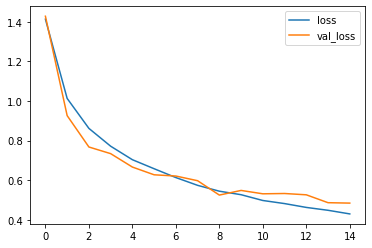

In [15]:
# Plot the cost function at each itteration
# Note: model.fit() returns an object that contains the history of the training process
plt.plot(result.history['loss'], label='loss');
plt.plot(result.history['val_loss'], label='val_loss');
plt.legend();

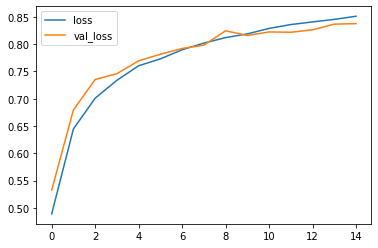

In [16]:
# Plot the cost function at each itteration
# Note: model.fit() returns an object that contains the history of the training process
plt.plot(result.history['accuracy'], label='loss');
plt.plot(result.history['val_accuracy'], label='val_loss');
plt.legend();

Confusion matrix, without Normalization
[[829  23  35  16  10   2   7   7  50  21]
 [  5 964   0   0   2   0   2   0   6  21]
 [ 37   2 750  33  45  34  65  26   3   5]
 [ 14   9  45 682  40  92  77  26   6   9]
 [  7   0  34  26 820   8  69  32   3   1]
 [  9   4  35 106  34 717  42  46   2   5]
 [  6   3  20  23   5   0 937   5   1   0]
 [ 12   3  11  15  21  23  13 892   3   7]
 [ 34  23   6   3   3   1   3   1 912  14]
 [ 15  84   4   4   1   1   4   3  11 873]]


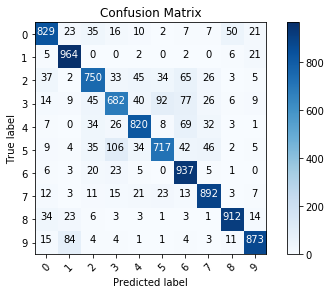

In [17]:
# Plot confusion matrix
p_test = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(K)))